

In this project, data mining techniques are implemented and applied to a real-world imbalanced dataset.

**Dataset:** Wisconsin Breast Cancer Diagnostic dataset from the UCI data repository: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

In [1]:
!pip install ucimlrepo

## Imports

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import itertools, collections
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from collections import Counter
import networkx as nx
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors

from ucimlrepo import fetch_ucirepo

## Load Data

In [7]:
# Fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# Data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# Metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

In [9]:
y_flat = y.values.ravel()
X_df = pd.DataFrame(X, columns=breast_cancer_wisconsin_diagnostic.feature_names)
y_df = pd.Series(y_flat, name='Diagnosis')
df = pd.concat([X_df, y_df], axis=1)


print(df)

     radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0      17.99     10.38      122.80  1001.0      0.11840       0.27760   
1      20.57     17.77      132.90  1326.0      0.08474       0.07864   
2      19.69     21.25      130.00  1203.0      0.10960       0.15990   
3      11.42     20.38       77.58   386.1      0.14250       0.28390   
4      20.29     14.34      135.10  1297.0      0.10030       0.13280   
..       ...       ...         ...     ...          ...           ...   
564    21.56     22.39      142.00  1479.0      0.11100       0.11590   
565    20.13     28.25      131.20  1261.0      0.09780       0.10340   
566    16.60     28.08      108.30   858.1      0.08455       0.10230   
567    20.60     29.33      140.10  1265.0      0.11780       0.27700   
568     7.76     24.54       47.92   181.0      0.05263       0.04362   

     concavity1  concave_points1  symmetry1  fractal_dimension1  ...  \
0       0.30010          0.14710     0.2419        

## Exploratory Data Analysis (EDA)

### Pairwise correlation between features

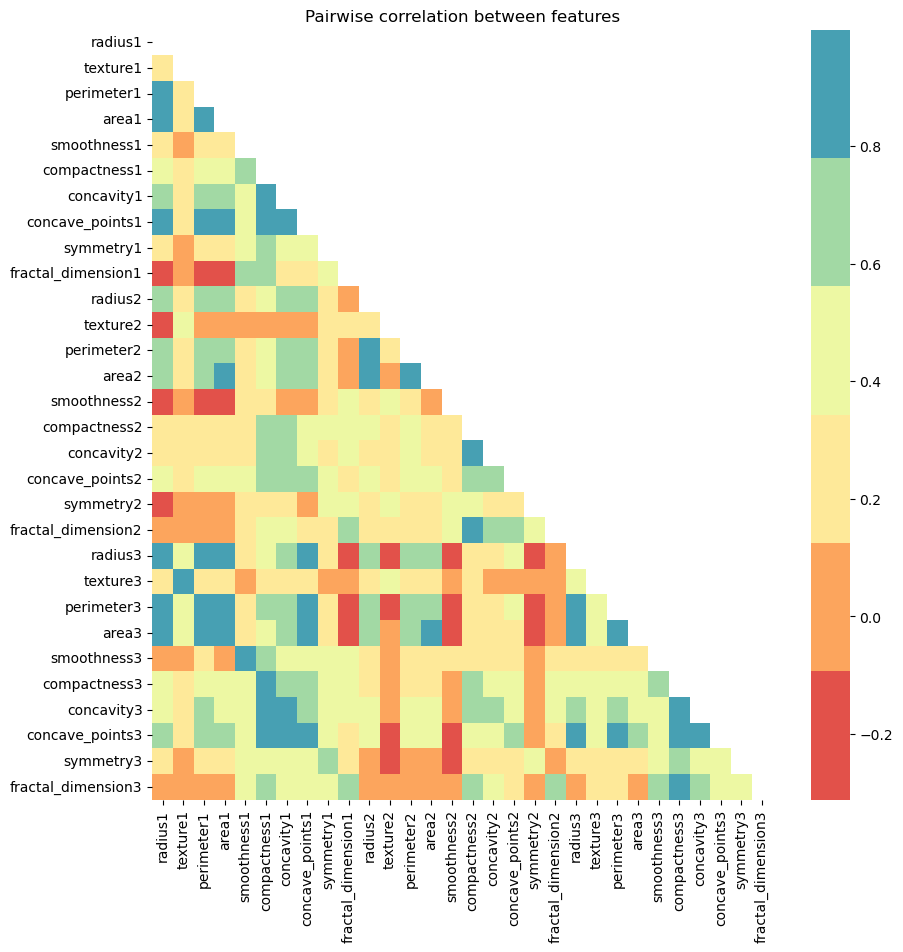

In [13]:
correlation = X.corr()

fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(correlation, annot=False, mask=np.triu(correlation),
            cmap=sns.color_palette("Spectral"))
ax.set_title("Pairwise correlation between features")
plt.show()

### Class-wise counts

In [16]:
print(collections.Counter(y['Diagnosis']))

Counter({'B': 357, 'M': 212})


### Class-wise features distributions

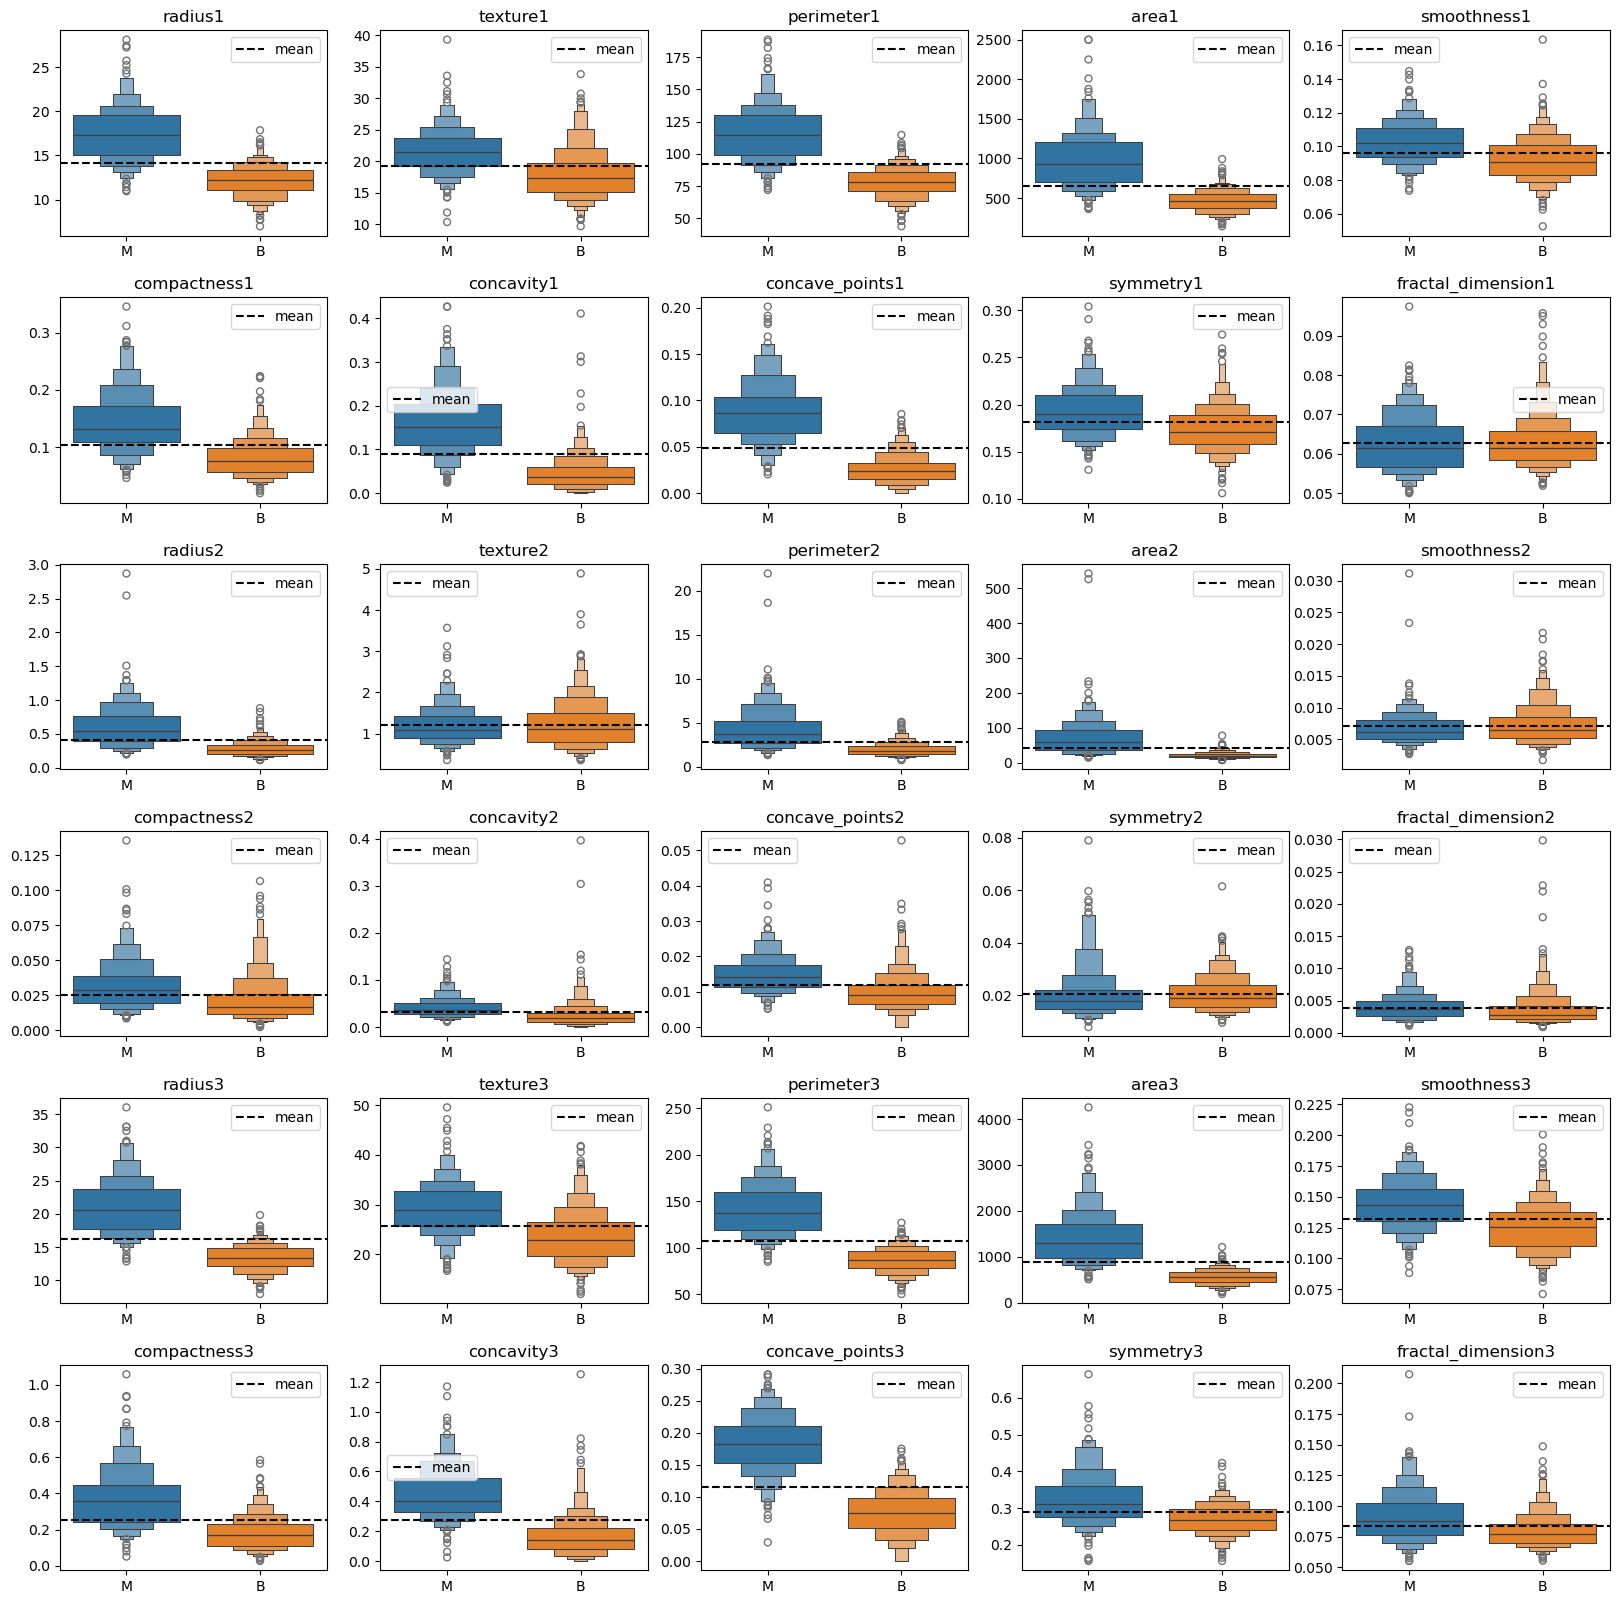

In [19]:
plt.figure(figsize=(20,20))

for i,j in itertools.zip_longest(list(X.columns), range(len(list(X.columns)))):
  plt.subplot(6,5,j+1)
  sns.boxenplot(x=y['Diagnosis'], y=X[i], hue=y['Diagnosis'])
  plt.title(i)
  plt.xlabel('')
  plt.ylabel('')
  plt.subplots_adjust(hspace=.3)
  plt.axhline(X[i].mean(), linestyle="dashed", color='k', label='mean')
  plt.legend(loc='best')

In [21]:
df_train, df_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=45)

In [23]:
target = 'Diagnosis'
features = [col for col in df.columns if col != target]
print(features)
train_data = pd.concat([df_train, y_train], axis=1)

['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3']


Diagnosis
B    357
M    212
Name: count, dtype: int64


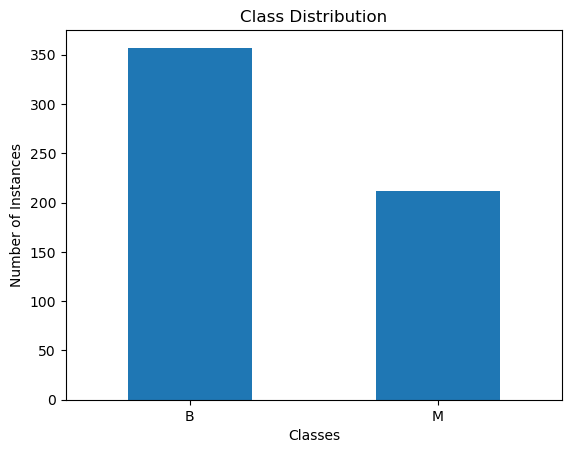

In [25]:
class_counts = df['Diagnosis'].value_counts()
print(class_counts)

class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Instances')
plt.xticks(rotation=0) 
plt.show()

In [27]:
print(df_train.columns)

Index(['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1',
       'compactness1', 'concavity1', 'concave_points1', 'symmetry1',
       'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2',
       'smoothness2', 'compactness2', 'concavity2', 'concave_points2',
       'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3',
       'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3',
       'symmetry3', 'fractal_dimension3'],
      dtype='object')


# Unsupervised Techniques

## k-Means clustering

*k-Means clustering Implementation:*

The *KMeans* class implements the K-Means clustering algorithm, which partitions data into k clusters. It supports both random and k-means++ initialization methods for centroids.

1.   X: Feature matrix (data points to be clustered).

2.   k: Number of clusters to form.

3.   max_iters: Maximum number of iterations to run the algorithm.

4.  tol: Tolerance to check for convergence (if the centroids don’t change significantly).

5.  init: Initialization method for centroids ("random" or "k-means++").

*Centroid Initialization:*

The K-Means algorithm uses two methods for centroid initialization: random and k-means++.

Random Initialization: Centroids are chosen randomly from the data points.

k-means++ Initialization: Centroids are selected based on their distance from existing centroids, improving the convergence rate.

*Clustering Process:*

1.  Initial centroids are chosen.
   
2.  Data points are assigned to the nearest centroid.
   
3.  New centroids are computed as the mean of the assigned data points.
   
4.  The algorithm iterates until convergence or the maximum number of iterations is reached.

*Silhouette Score Calculation and Plotting:*

The silhouette score measures clustering quality by evaluating how well-defined the clusters are. A higher silhouette score (closer to 1) indicates better-defined clusters, while a negative score suggests poor clustering

The average silhouette score and standard deviation across runs are plotted for different values of k and initialization methods to visualize how the number of clusters and centroid initialization affect clustering performance.

In [64]:
# [YOUR IMPLEMENTATION CODE HERE]
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from scipy.spatial.distance import cdist

class KMeans:
    def __init__(self, k=3, max_iters=300, tol=1e-4, init="random"):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
        self.init = init
        self.centroids = None

    def initialize_centroids(self, X):
        if self.init == "k-means++":
            centroids = [X[np.random.randint(X.shape[0])]]
            for _ in range(1, self.k):
                distances = np.min(cdist(X, np.array(centroids)), axis=1)
                probs = distances / distances.sum()
                next_centroid = X[np.random.choice(X.shape[0], p=probs)]
                centroids.append(next_centroid)
            return np.array(centroids)
        else:  # Random initialization
            indices = np.random.choice(X.shape[0], self.k, replace=False)
            return X[indices]

    def fit(self, X):
        self.centroids = self.initialize_centroids(X)
        for i in range(self.max_iters):
            distances = cdist(X, self.centroids)
            labels = np.argmin(distances, axis=1)


            new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(self.k)])

            if np.all(np.linalg.norm(new_centroids - self.centroids, axis=1) < self.tol):
                break
            self.centroids = new_centroids
        return labels

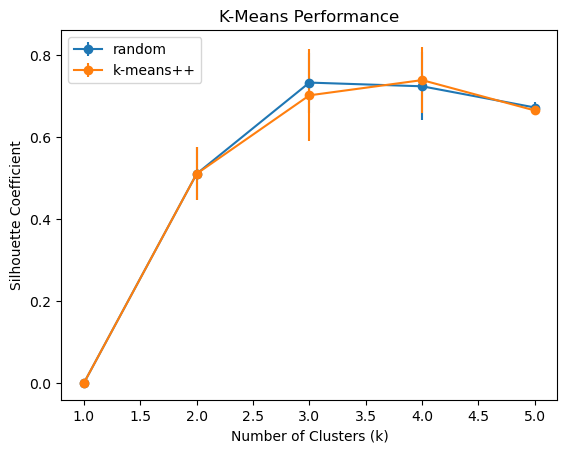

In [66]:
# [YOUR PLOTTING CODE HERE]
X, _ = make_blobs(n_samples=300, centers=4, random_state=42)
ks = range(1, 6)
init_methods = ["random", "k-means++"]

for init in init_methods:
    silhouette_means = []
    silhouette_stds = []
    for k in ks:
        scores = []
        for _ in range(10):
            kmeans = KMeans(k=k, init=init)
            labels = kmeans.fit(X)
            if k > 1:
                scores.append(silhouette_score(X, labels))
            else:
                scores.append(0)
        silhouette_means.append(np.mean(scores))
        silhouette_stds.append(np.std(scores))
    plt.errorbar(ks, silhouette_means, yerr=silhouette_stds, label=f"{init}", marker='o')

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Coefficient")
plt.title("K-Means Performance")
plt.legend()
plt.show()

## Density-based clustering with DBSCAN

*DBSCAN Implementation:*

The DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm is a density-based clustering method that groups together points that are closely packed together, marking points that lie alone in low-density regions as outliers.

Parameters:

1.  X: Feature matrix (data points to be clustered).

2.  eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.

3.  min_pts: The number of samples in a neighborhood for a point to be considered as a core point.

Clustering Process:

For each point in the dataset:

1.  If the point is already labeled, continue to the next point.

2.  Find all neighbor points within eps distance.

3.  If the number of neighbors is less than min_pts, label the point as noise.

4.  Otherwise, start a new cluster and expand it.
   
Cluster Expansion:

1.  Add the current point to the cluster.
   
2.  For each neighbor:
   
If it's not yet visited, add it to the cluster and continue expanding from this point.
If it was previously marked as noise, add it to the cluster.

*Euclidean Distance Function:*
Calculates the Euclidean distance between two points in the feature space.

*Region Query Function:*
Finds the neighbors of a given point within a specified distance (eps).

*Expand Cluster Function:*
Expands the current cluster by recursively visiting neighboring points and assigning them to the same cluster.

In [70]:
# [YOUR IMPLEMENTATION CODE HERE]
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def region_query(X, point_idx, eps):
    neighbors = []
    for idx, point in enumerate(X):
        if euclidean_distance(X[point_idx], point) <= eps:
            neighbors.append(idx)
    return neighbors

def expand_cluster(X, labels, point_idx, cluster_id, neighbors, eps, min_pts):
    labels[point_idx] = cluster_id
    i = 0
    while i < len(neighbors):
        neighbor_idx = neighbors[i]
        if labels[neighbor_idx] == -1: 
            labels[neighbor_idx] = cluster_id
        elif labels[neighbor_idx] == 0: 
            labels[neighbor_idx] = cluster_id
            new_neighbors = region_query(X, neighbor_idx, eps)
            if len(new_neighbors) >= min_pts:
                neighbors.extend(new_neighbors)
        i += 1

def dbscan(X, eps, min_pts):
    labels = np.zeros(len(X), dtype=int)  
    cluster_id = 0

    for point_idx in range(len(X)):
        if labels[point_idx] != 0:  
            continue
        neighbors = region_query(X, point_idx, eps)
        if len(neighbors) < min_pts:
            labels[point_idx] = -1  
        else:
            cluster_id += 1
            expand_cluster(X, labels, point_idx, cluster_id, neighbors, eps, min_pts)

    return labels

np.random.seed(45)
X = np.random.rand(300, 2)  

eps_values = [0.1, 0.2]
min_pts_values = [5, 10, 15, 20]
results = {eps: [] for eps in eps_values}

for eps in eps_values:
    mean_scores = []
    std_scores = []

    for min_pts in min_pts_values:
        scores = []

        for run in range(10):
            random_state = np.random.randint(0, 1000)
            labels = dbscan(X, eps, min_pts)

            
            if len(set(labels)) > 1 and -1 in labels:
                score = silhouette_score(X, labels)
                scores.append(score)
            else:
                scores.append(-1)

        mean_scores.append(np.mean(scores))
        std_scores.append(np.std(scores))

    results[eps] = (mean_scores, std_scores)

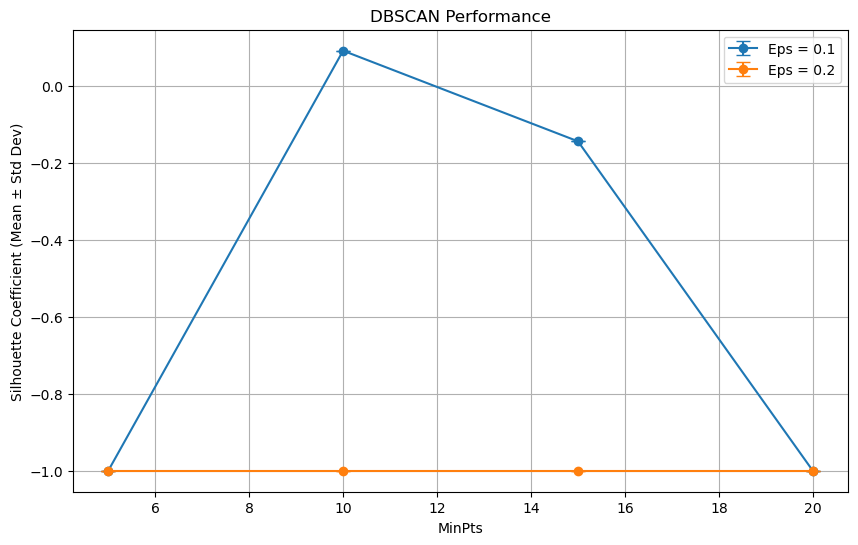

In [72]:
# [YOUR PLOTTING CODE HERE]
plt.figure(figsize=(10, 6))
for eps in eps_values:
    mean_scores, std_scores = results[eps]
    plt.errorbar(min_pts_values, mean_scores, yerr=std_scores, label=f"Eps = {eps}",
                 capsize=5, marker='o')

plt.title("DBSCAN Performance")
plt.xlabel("MinPts")
plt.ylabel("Silhouette Coefficient (Mean ± Std Dev)")
plt.legend()
plt.grid()
plt.show()

## Graph-based clustering with Spectral Clustering

Spectral Clustering, a powerful clustering algorithm that uses graph theory to partition data points into clusters based on their similarity.

<b>Gaussian Similarity Matrix - </b>

The function gaussian_similarity(X, sigma) computes the similarity matrix 
W, which represents the pairwise similarity between data points. The Gaussian kernel is used to calculate the similari Wij = exp( - (||xi - xj||^2 / (2 (sigma) ^2)))

Here 
xi, xj denote the data points and sigma denotes the parameter controlling the width of Gaussian Kernel

<b>Unnormalized Spectral Clustering - </b>

Spectral Clustering is done using the unnormalized Laplacian matrix

Degree Matrix is computed where each diagonal entry is the sum of Wij (similarity matrix)  across all j.

Laplacian Matrix is computed from the similarity matrix and degree matrix  L = D - W

k eigen vectors of L are extracted and these represent the reduced form of data, here the value of k is given as parameter to the function

By applying kmeans algorithm, rows of the normalized eigenvector matrix are clustered together.

In [ ]:
# [YOUR IMPLEMENTATION CODE HERE]
from sklearn.preprocessing import StandardScaler

def gaussian_similarity(X, sigma):
    squared_dists = np.sum((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2, axis=2)
    W = np.exp(-squared_dists / (2 * sigma**2))
    return W

def spectral_clustering(X, k, sigma, max_iterations=100, tol=1e-4):
    W = gaussian_similarity(X, sigma)

    D = np.diag(np.sum(W, axis=1))

    L = D - W

    eigenvalues, eigenvectors = np.linalg.eigh(L)
    indices = np.argsort(eigenvalues)[:k]
    U = eigenvectors[:, indices]

    U_normalized = U / np.linalg.norm(U, axis=1, keepdims=True)

    kmeans = KMeans(k=k, max_iters=max_iterations, tol=tol, init="k-means++")
    labels = kmeans.fit(U_normalized)

    return labels, kmeans.centroids

def spectral_clustering_k(X, k_range, sigma_values, n_runs=10):
    results = {}
    for sigma in sigma_values:
        sigma_results = []
        for k in k_range:
            k_scores = []
            for _ in range(n_runs):
                clusters, _ = spectral_clustering(X, k, sigma)
                if k > 1:
                    score = silhouette_score(X, clusters)
                else:
                    score = 0
                k_scores.append(score)
            mean_score = np.mean(k_scores)
            std_score = np.std(k_scores)
            sigma_results.append((k, mean_score, std_score))
        results[sigma] = sigma_results
    return results

X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_range = range(2, 6)
sigma_values = [0.1, 1, 10]
spectral_results = spectral_clustering_k(X_scaled, k_range, sigma_values)

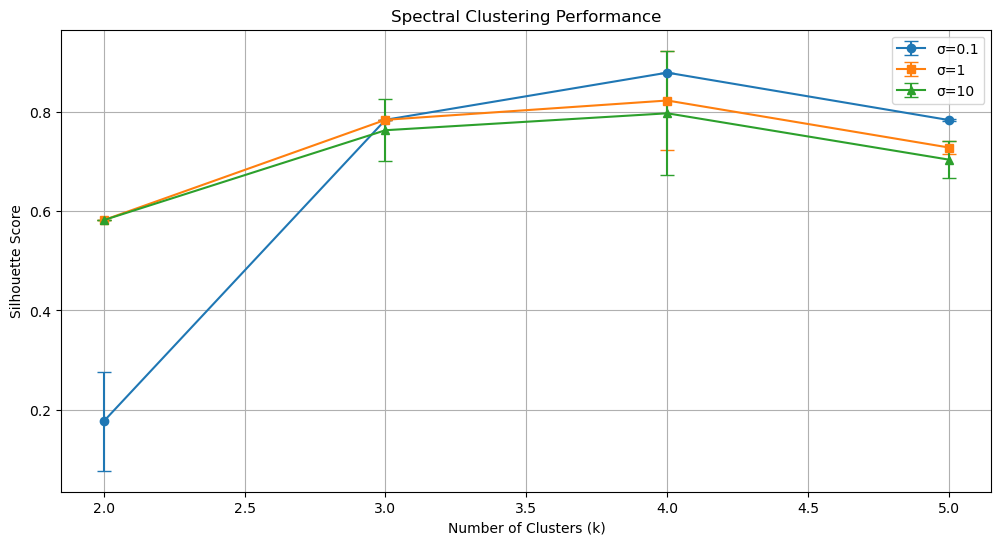

In [ ]:
# [YOUR PLOTTING CODE HERE]
plt.figure(figsize=(12, 6))
markers = ['o', 's', '^']
for i, sigma in enumerate(sigma_values):
    k_values, means, stds = zip(*spectral_results[sigma])
    plt.errorbar(k_values, means, yerr=stds, fmt=f'-{markers[i]}',
                 capsize=5, label=f'σ={sigma}')

plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Spectral Clustering Performance')
plt.legend()
plt.grid(True)
plt.show()

## Anomaly detection with the Isolation Forest

<b> Isolation Forest Class </b> 
The anomalies are identified by randomly partitioning the data points and measuring their path lengths in isolation trees
 
build_forest - this method computes the isolation forest by creating multiple isolation trees.
build_isolationforest - this recursively builds an isolation tree by randomly selecting a feature and split value
compute_anomaly_scores - this method is used to calculate the anomaly scores for the input data points by combining the path lengths across all trees. Higher score indicates higher likelihood of the datapoint being an anomaly.

 

<b> Anomaly Detection and Cluster Anlysis </b> 

The input data is scaled and isolation forest are built using IsolationForest class and anomaly scores are computed. Different contamination levels (1%, 5%, 10%, and 15%) are used to identify anomalies.
For each contamination level, a threshold is set based on the anomaly scores, and data points with scores above this threshold are marked as anomalies.
Anomalies that are identified are removed from the dataset, leaving only "normal" data points for further analysis.

K-Means clustering (with k=2) is applied to the cleaned dataset for each contamination level.

The Silhouette Score is used to evaluate clustering quality.

The output features contamination percentage, silhouette score and no of remaining data points after cleaning.

In [110]:
# [YOUR IMPLEMENTATION CODE HERE]

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
import numpy as np
import math

class Node:
    def __init__(self, size=0, left=None, right=None, split_att=None, split_value=None):
        self.size = size
        self.left = left
        self.right = right
        self.split_att = split_att
        self.split_value = split_value
        self.is_external = (left is None and right is None)


class IsolationForest:
    def __init__(self, n_trees=100, sample_size=256):
        self.n_trees = n_trees
        self.sample_size = sample_size
        self.trees = []
        self.height_limit = math.ceil(math.log2(sample_size))

    def build_forest(self, X):
        self.trees = []
        for i in range(self.n_trees):
            indices = np.random.randint(0, X.shape[0], self.sample_size)
            X_sample = X[indices]
            tree = self.build_isolationtree(X_sample, 0, self.height_limit)
            self.trees.append(tree)
        return self

    def build_isolationtree(self, X, current_height, height_limit):
        if current_height >= height_limit or len(X) <= 1:
            return Node(size=len(X))

        split_att = np.random.randint(0, X.shape[1])
        x_max = X[:, split_att].max()
        x_min = X[:, split_att].min()
        split_value = np.random.uniform(x_min, x_max)

        left_indices = X[:, split_att] < split_value
        right_indices = ~left_indices

        node = Node(
            size=len(X),
            split_att=split_att,
            split_value=split_value,
            left=self.build_isolationtree(X[left_indices], current_height + 1, height_limit),
            right=self.build_isolationtree(X[right_indices], current_height + 1, height_limit)
        )

        return node

    def path_length(self, x, tree, current_height=0):
        if tree.is_external:
            return current_height + self.c(tree.size)

        if x[tree.split_att] < tree.split_value:
            return self.path_length(x, tree.left, current_height + 1)
        else:
            return self.path_length(x, tree.right, current_height + 1)

    def c(self, n):
        if n <= 1:
            return 0
        return 2 * (np.log(n - 1) + 0.5772156649) - (2 * (n - 1) / n)

    def compute_anomaly_scores(self, X):
        scores = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            path_lengths = [self.path_length(X[i], tree) for tree in self.trees]
            avg_path_length = np.mean(path_lengths)
            scores[i] = 2 ** (-avg_path_length / self.c(self.sample_size))
        return scores

    
def analyze_with_isolation_forest(X_df):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_df)

    iso_forest = IsolationForest(n_trees=100, sample_size=256)
    iso_forest.build_forest(X_scaled)
    anomaly_scores = iso_forest.compute_anomaly_scores(X_scaled)

    contamination_levels = [0.01, 0.05, 0.10, 0.15]
    results = []

    for contamination in contamination_levels:
        threshold = np.percentile(anomaly_scores, (1 - contamination) * 100)
        normal_mask = anomaly_scores < threshold
        X_cleaned = X_scaled[normal_mask]

        kmeans = KMeans(k=2, init="k-means++")
        clusters = kmeans.fit(X_cleaned)
        silhouette_avg = silhouette_score(X_cleaned, clusters)

        results.append({
            'contamination': contamination,
            'silhouette_score': silhouette_avg,
            'n_remaining': len(X_cleaned),
            'normal_mask': normal_mask,
            'clusters': clusters,
            'centroids': kmeans.centroids,
            'X_cleaned': X_cleaned
        })

    return results, X_scaled, anomaly_scores

results, X_scaled, anomaly_scores = analyze_with_isolation_forest(X_df)





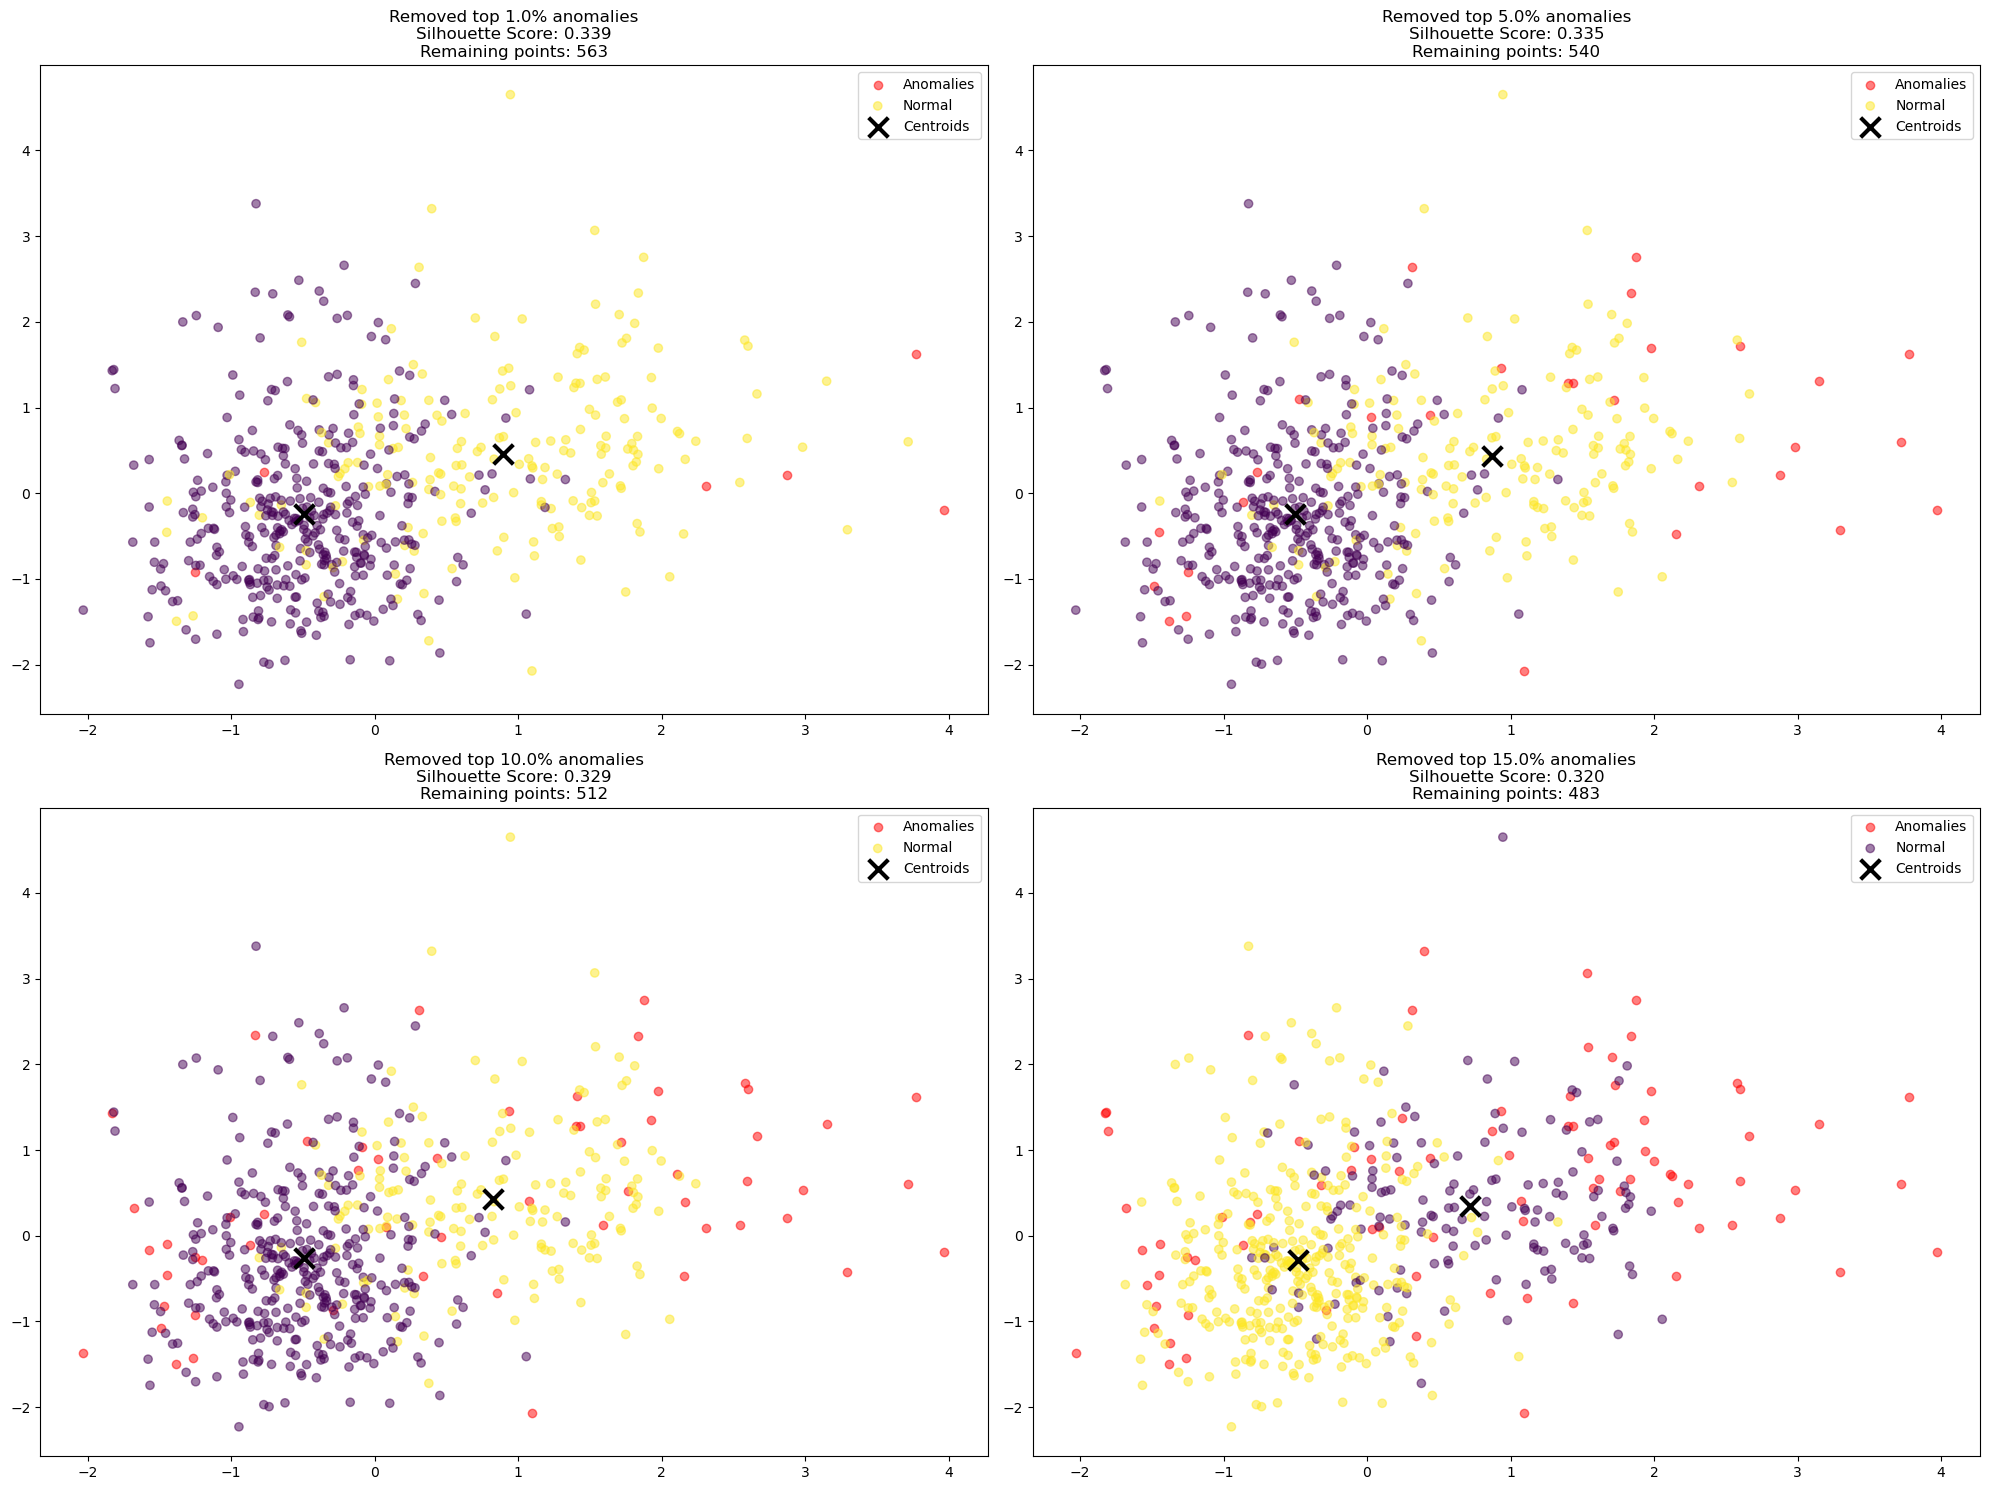


Detailed Results:

Contamination Level: 1.0%
Silhouette Score: 0.339
Remaining Points: 563

Contamination Level: 5.0%
Silhouette Score: 0.335
Remaining Points: 540

Contamination Level: 10.0%
Silhouette Score: 0.329
Remaining Points: 512

Contamination Level: 15.0%
Silhouette Score: 0.320
Remaining Points: 483


In [108]:
# [YOUR PLOTTING CODE HERE]


plt.figure(figsize=(20, 15))
for idx, result in enumerate(results):
    contamination = result['contamination']
    normal_mask = result['normal_mask']
    clusters = result['clusters']
    centroids = result['centroids']
    X_cleaned = result['X_cleaned']
    silhouette_avg = result['silhouette_score']

    plt.subplot(2, 2, idx + 1)

    plt.scatter(X_scaled[~normal_mask, 0], X_scaled[~normal_mask, 1],
               c='red', alpha=0.5, label='Anomalies')

    plt.scatter(X_cleaned[:, 0], X_cleaned[:, 1],
               c=clusters, cmap='viridis', alpha=0.5, label='Normal')

    plt.scatter(centroids[:, 0], centroids[:, 1],
               c='black', marker='x', s=200, linewidths=3, label='Centroids')

    plt.title(f'Removed top {contamination*100}% anomalies\n'
             f'Silhouette Score: {silhouette_avg:.3f}\n'
             f'Remaining points: {len(X_cleaned)}')
    plt.legend()

plt.tight_layout()
plt.show()

print("\nDetailed Results:")
for result in results:
    print(f"\nContamination Level: {result['contamination']*100}%")
    print(f"Silhouette Score: {result['silhouette_score']:.3f}")
    print(f"Remaining Points: {result['n_remaining']}")


# References / Disclosures

Research Papers :



- Arthur, D. and Vassilvitskii, S., 2007, January. k-means++: The advantages of careful seeding. In Soda (Vol. 7, pp. 1027-1035)

- Von Luxburg, U. (2007). A tutorial on spectral clustering. Statistics and Computing, 17(4), 395–416. https://doi.org/10.1007/s11222-007-9033-z

- Liu, F. T., Ting, K. M., & Zhou, Z.-H. (2008). Isolation Forest. 2008 Eighth IEEE International Conference on Data Mining, 413–413.   
  https://ieeexplore.ieee.org/document/4781138


Websites :

- https://towardsdatascience.com/a-practical-guide-to-dbscan-method-d4ec5ab2bc99l

- https://www.analyticsvidhya.com/blog/2021/05/what-why-and-how-of-spectral-clustering/

- https://www.33rdsquare.com/what-why-and-how-of-spectral-clustering/

- https://machinelearningmastery.com/anomaly-detection-with-isolation-forest-and-kernel-density-estimation/

- https://towardsdatascience.com/isolation-forest-the-anomaly-detection-algorithm-any-data-scientist-should-know-1a99622eec2d




